# Model testing

Evaluate the saved XGBoost regressor on the held-out test dataset.

### Imports

In [1]:
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os

### Variables

In [2]:
target_col = "movie_score"
drop_cols = ["movie_score", "averageRating", "numVotes", "Unnamed: 0", "_orig_order"]

### Retrieve data

In [5]:
testDatasetPath = os.path.join('..','..', 'data', 'test_dataset.csv')
final_model = joblib.load("random_forest_reg_movie_log_transformed.joblib")
df_test = pd.read_csv(testDatasetPath, sep=";")


### Prepare test data

In [6]:
# Load model and data, transform the log scalled data back
y_true = np.expm1(df_test[target_col].values)
X_test = df_test.drop(columns=[c for c in drop_cols if c in df_test.columns])


### Create prediction on test

In [7]:
# Predict and turn the prediction back to normal scale 
y_pred = np.expm1(final_model.predict(X_test))

/Library/Frameworks/Python.framework/Versions/3.14/lib/python3.14/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


### Calculate MAE, RMSE and R^2

In [8]:
# Metrics (only if ground truth available)
if y_true is not None:
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"MAE:  {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2:   {r2:.4f}")
else:
    print("Ground-truth 'movie_score' not found in test set; only predictions are available.")


MAE:  2122.8651
RMSE: 17464.0752
R2:   0.4420


### Create a preview dataframe

In [9]:
# Preview predictions
preview = pd.DataFrame({"predicted_movie_score": y_pred, "residual": y_pred - y_true})
if y_true is not None:
    preview.insert(0, "actual_movie_score", y_true)


### Create a dataframe of feature importance

In [15]:
importances = final_model.feature_importances_
feature_names = X_test.columns

# Create sorted DataFrame
importance_df = (
    pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
)
print(importance_df.head(10))

                       feature  importance
4       prior1_rating_director    0.118331
8   actor1_prior2_rating_actor    0.061118
5       prior2_rating_director    0.059245
9   actor1_prior3_rating_actor    0.057822
7   actor1_prior1_rating_actor    0.052243
6       prior3_rating_director    0.041438
11  actor2_prior1_rating_actor    0.037024
12  actor2_prior2_rating_actor    0.035494
13  actor2_prior3_rating_actor    0.028491
15  actor3_prior1_rating_actor    0.027585


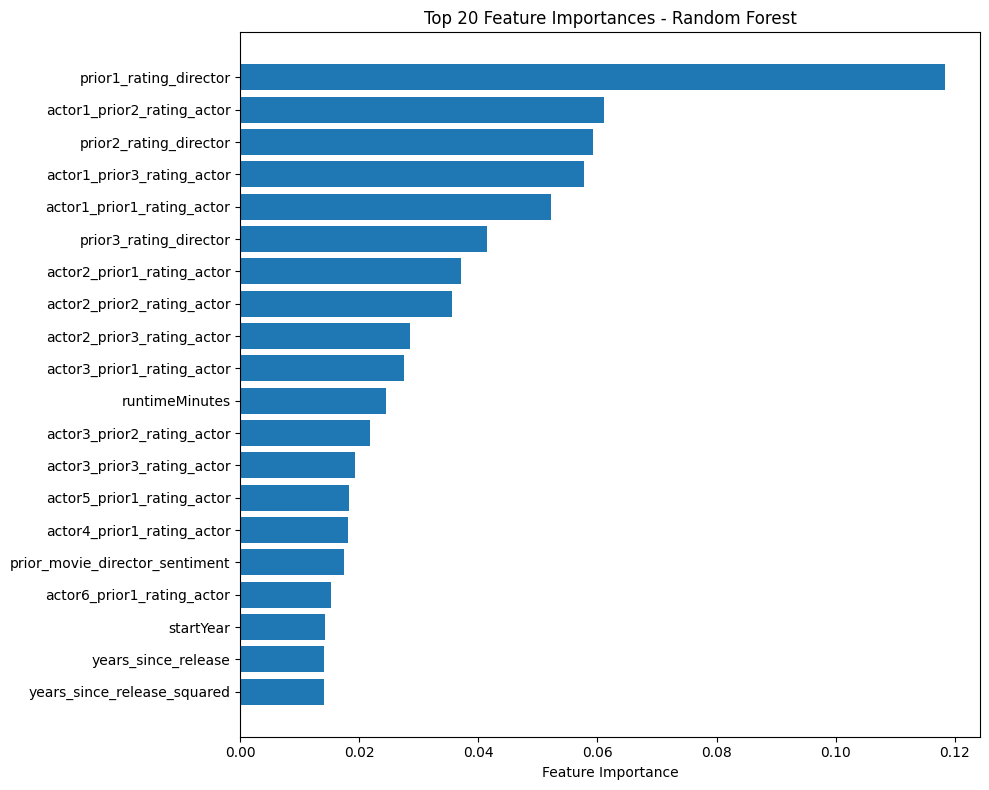

In [18]:
# Visualize top 20 feature importances
plt.figure(figsize=(10, 8))
top_features = importance_df.head(20)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Feature Importances - Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


### Graph over residuals

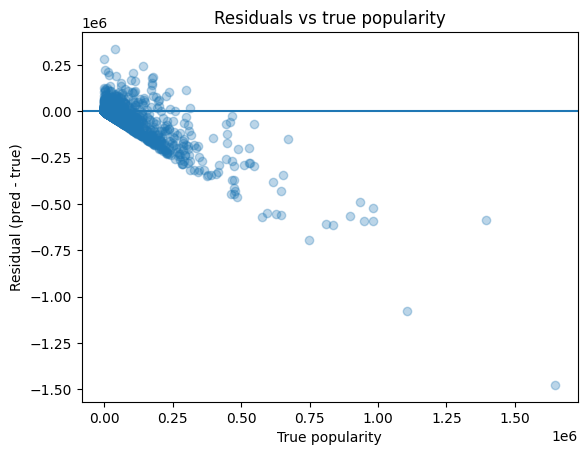

In [12]:
residuals = y_pred - y_true

plt.figure()
plt.scatter(y_true, residuals, alpha=0.3)
plt.axhline(0)
plt.xlabel("True popularity")
plt.ylabel("Residual (pred - true)")
plt.title("Residuals vs true popularity")
plt.show()


### Bias plot

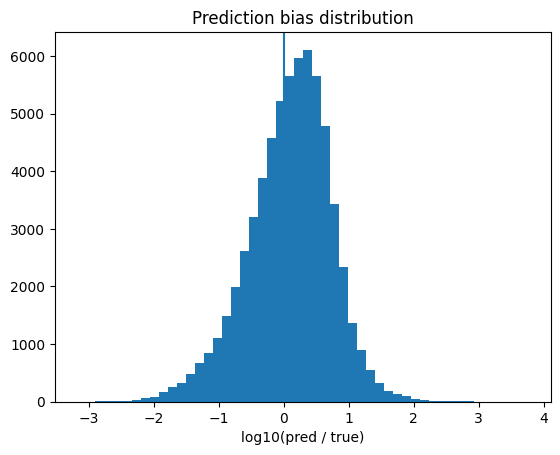

In [13]:
ratio = y_pred / (y_true + 1e-9)
plt.figure()
plt.hist(np.log10(ratio), bins=50)
plt.axvline(0)  # log10(1)
plt.xlabel("log10(pred / true)")
plt.title("Prediction bias distribution")
plt.show()

